## Synthesis example for odd order elliptic lowpass filters
Based on the paper ***_On the Design of Filters by Synthesis_*** by Saal and Ulbrich   
https://ieeexplore.ieee.org/document/1086481   
**_Warning, the notations used in this paper is dated!_**  
  
(example from page 304)
### 4) _Low-Pass_ C 03 20 21: 


$n = 3$  
${\rho} = 20\ \%$  
${\theta} = 21$ &deg;

The relationship between ${\theta}$ and ${\Omega}_{s}$, the normalized stopband frequency, is the following:

${\Omega}_{s}=\displaystyle\frac{1}{sin{\theta}}=2.790428\ rad$  

See the last paragraph on the left half of page 292.

The cutoff frequency (equi-ripple) ${\Omega}_{c}$ is set to 1 as usual.

In [21]:
import numpy as np
#np.seterr(divide='ignore', invalid='ignore')

import scipy.special as ss
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
# number of section
n = 3  

# reflection coefficient of filter
p = 0.2   

# ws=2.790428, normalized stopband frequency
theta_deg = 21  

# convert theta to radians for later calculations
theta = theta_deg*np.pi/180  

# calculate ws from theta
ws = 1/np.sin(theta)

#print("n = ", n)
#print("p = ", p)
#print("theta = ", theta_deg, "deg")

Calculate ${a}_{v}$ using _equation (38)_ on page 294.  

${a}_{v} = \sqrt{sin{\theta}}  \cdot sn\bigg(\displaystyle\frac{v}{n}K;{\theta}\bigg)\;\;\;\;\;\;v=1,\;2,\;...,\;n-1$ 



The variable $K$ is the complete elliptic integral of the first kind with the modulus $k=sin{\theta}$.  
The function $sn(u,m)$ is the Jacobian elliptic function.  



In [23]:
#In scipy library: ellipk(u,m) is the complete elliptic integral of the first kind where m = k^2 or sin^2(theta)
K = ss.ellipk(np.sin(theta)**2)

#a[0] is filled with a dummy 1 so indices of a[] complies with Saal & Ulbrich(SU)
a = np.array([1])   
for v in range(1, n):    
    u = K*v/n
    #In scipy library: ellipj(u,m) is the Jacobian elliptic function where m = sin^2(theta)
    jac_ell = ss.ellipj(u, np.sin(theta)**2)
    sn = jac_ell[0]
    a = np.append(a, np.sqrt(np.sin(theta))*sn)
    
#print(a[1:])

Calculate ${a}_{n}$ using _equation (38)_ on page 294.

${a}_{n} = {\Omega}^{'}_{c} = \displaystyle\frac{1}{{\Omega}^{'}_{s}} = \sqrt{sin{\theta}} < 1$  

These additional normalization of the cutoff and stopband frequencies were necessitated by the computational limitations of the 1950s.  Read paragraph below _equation (38)_ on page 294.   


In [24]:
#Append a[n] into the array a.
a = np.append(a, np.sqrt(np.sin(theta)))

wc_p = a[n]

#print(a[1:])

Calculate  $m$ and ${\Delta}$ using _equations (37)_ and _(39)_ respectively on page 294 for $n$ being odd.

$m = \displaystyle\frac{n-1}{2}$

${\Delta} = \displaystyle\frac{1}{{a}_{n}}\prod_{{\mu} = 1}^{m + 1} {a}^{2}_{2{\mu} - 1}$

In [25]:
m = (n-1)//2 

delta = 1
for u in range(1, m+2):
    delta *= a[2*u-1]**2
delta = 1.0/a[n]*delta

#print(delta)

These intermediate results from the paper are listed below:

${a}_{2} = 0.522813$  

${a}_{3} = 0.598638 = {\Omega}^{'}_{c} < 1 \;\;\;\;$  In the paper, the $^{'}$(prime) in ${\Omega}^{'}_{c}$ had been omitted. 

${\Delta} = 0.0564327$  
___

Now that ${\Delta}$ is available, the rejection ${A}_{s}$ in $dB$ should be calculated.  See _equation (40)_ on page 294.  

${A}_{s} = 10\log_{10} \displaystyle \left[1+\frac{1}{\Delta^{4}({\rho}^{-2}-1)}\right]$

In [26]:
#See EQN(40) page 294 for rejection calculation.
As = 10*np.log10(1+1/((delta**4)*(1/p**2-1))) #dB

#print(As)

___

### a) The characteristic function $K({\lambda})$, ...
Construct the characteristic polynomial $K({\lambda})$.  See _equation (37)_ on page 294.  

$K({\lambda}) = \displaystyle \frac{1}{{c}^{-1}}\cdot {\lambda}\prod_{{\mu} = 1}^{m} \displaystyle \frac{{\lambda}^{2}+{{a}^{2}_{2{\mu}}}} {{a}^{2}_{2{\mu}} \cdot {\lambda}^{2}+1}$


${c}^{-1} = {\Delta}\sqrt{{\rho}^{-1} - 1}$

For $m=1$, the characteristic polynomial is shown below:

$K({\lambda}) = \displaystyle \frac{1}{{c}^{-1}}{\lambda}\displaystyle \frac{{\lambda}^{2}+{{a}^{2}_{2}}} {{a}^{2}_{2} {\lambda}^{2}+1}$

The polynomial $K({\lambda})$ has the numnerator and denominator $F({\lambda})$ and $P({\lambda})$ respectively.  See _equation (12)_ on page 286. 

$K({\lambda}) = \displaystyle \frac{F({\lambda})} {P({\lambda})}$

In [27]:
#c calculation from page 304
c = 1/(delta*np.sqrt(1/(p**2)-1))

#EQN(37) p294, form and expand polynomial K for n odd
#F is the numerator of K
#P is the denominator of K
F = np.array([1,0])   #initialize F array with lambda
P = np.array([1/c])   #initialize P array with constant c

#These are the inverse of the transmission zero frequencies
co_tz = np.array([])

for u in range(1, m+1):
    F = np.polymul(F, [1, 0, a[2*u]**2])
    P = np.polymul(P, [a[2*u]**2, 0, 1])
    
    #collect the constants a used in P(lambda)
    co_tz = np.append(co_tz, a[2*u])

#print(F)
#print(P)

From the paper,

$K({\lambda}) = \displaystyle \frac{{\lambda}^{3} + 0.273333{\lambda}} {0.0755665{\lambda}^{2} + 0.276463}$  


$F({\lambda}) = {\lambda}^{3} + 0.273333{\lambda}$

$P({\lambda}) = {0.0755665{\lambda}^{2} + 0.276463}$
___

### Lowpass Filter Response
Once the characteristic polynomial $K({\lambda})$ has been found,  a plot of the filter response can be generated to check the validity of the calculations.

Form polynomial $\lvert K({\lambda}) \rvert ^{2}$, where ${\lambda} = j{\Omega}$.        
  
$\lvert K({\lambda}) \rvert ^{2}=\displaystyle \frac{F({\lambda})F({-\lambda})} {P({\lambda})P({-\lambda})}$   

In [28]:
#Generate F(jw)*F(-jw) and P(jw)*p(-jw) for n even

#nX = X(-jw).  Changes sign of coefficients of odd order only.
nF = np.copy(F)
nP = np.copy(P)

#Odd order indexing from penultimate element while stepping by 2 in reverse. 
nF[-2::-2] = -1*nF[-2::-2]
nP[-2::-2] = -1*nP[-2::-2]
    
FnF = np.polymul(F, nF)
PnP = np.polymul(P, nP)

#print(FnF)
#print(PnP)

The $\lvert S_{21} \rvert^2$ is related to $\lvert K({\lambda}) \rvert ^{2}$ by the following:

$\lvert S_{21} \rvert ^2 = \displaystyle \frac{1} {1 + \lvert K({\lambda}) \rvert ^{2}}$     
  
Applying conservation of energy,  
  
$\lvert S_{11} \rvert^2 = 1-\lvert S_{21} \rvert ^2$
  
When evaluating $\lvert K({\lambda}) \rvert ^{2}$, ${\lambda} = j{\Omega}$ and ${\Omega}$ is normalized to ${\Omega}^{'}_{c}$.  For example, when plotting the value at ${\Omega} = 1$, $\lvert K({\lambda}) \rvert ^{2}$ should be evaluated for ${\lambda} = j1 \cdot {\Omega}^{'}_{c}$.  

In [29]:
def Plot_S(S11_dB, S21_dB, w, ws, rej_dB, title = '???', fig = 1):
    #test plot of transfer function 
    
    #plt.clf()
    plt.figure(fig, (10, 6))
    plt.plot(w, S21_dB, label = '$|S_{21}|^2$')
    plt.plot(w, S11_dB, label = '$|S_{11}|^2$')
    plt.legend(loc = 'lower right', shadow=False, fontsize = 'large')
    
    #Plot stop band limits
    As = -1*rej_dB
    plt.plot([ws, w[-1]], [As, As], 'g', linestyle=':')
    plt.plot([ws, ws], [As, 0], 'g', linestyle=':')
    txt = '('+ str(round(ws, 2)) + ', ' + str(np.ceil(As)) + ')' 
    plt.text(ws + .01*w[-1], round(As,0)+1, txt, fontsize = 12)
    
    #Limit the lower y-axis to 20dB below the rejection rounded to x10. E.g. 43->50  
    plt.axis([0, w[-1], np.floor(As/10)*10-20, 0])
    plt.xticks(np.arange(0, w[-1]+1, 1))
    
    plt.xlabel('${\Omega}$(rad)', fontsize = 'large')
    plt.ylabel('(dB)', fontsize = 'large')
    plt.title(title, fontsize = 'large')

    plt.grid()
    plt.show()

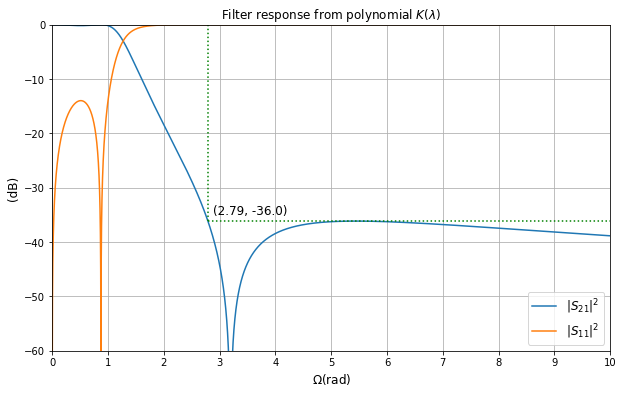

In [30]:
#Generate the lambdas to be evaluated
wstep = .001
w = np.arange(wstep, 10, wstep)
lamb = 1j*w*wc_p 
        
Kn2 = np.polyval(FnF,lamb)
Kd2 = np.polyval(PnP,lamb) 
K2 = np.real(Kn2)/np.real(Kd2)

S21_2 = 1/(1+K2)
S21_dB = 10*np.log10(S21_2)

S11_2 =  1-S21_2 
S11_dB = 10*np.log10(S11_2)

title = 'Filter response from polynomial $K({\lambda})$'

Plot_S(S11_dB, S21_dB, w, ws, As, title)

___

### b) The Hurwitz polynomial $E({\lambda})$. ...
Construct the polynomial $E({\lambda})$ for odd $n$.  See left half of page 295.


$E({\lambda}) = \displaystyle ({\lambda}-{\lambda}_{o})\prod_{{\mu} = 1}^{m} \displaystyle ({\lambda}^{2}-{p}_{\mu}{\lambda}+{q}_{\mu})$


To find ${\lambda}_{o}$, find the real root of the polynomial $F({\lambda})+P({\lambda})$.  There should be only one real root and it is equal to ${\lambda}_{o}$.

Read this section (starting from the bottom right half of page 304 to the top left of page 306) for the explanation on why it is sufficient to just find the roots of $F({\lambda})+P({\lambda})$.


In [31]:
#Form F+P. Top left of page 306. Read the explanation on why roots for F+P is sufficient
FplusP = np.polyadd(F,P)

#Find the only root with no imaginary part
FplusP_roots = np.roots(FplusP)
for i in range(len(FplusP_roots)):
    if np.imag(FplusP_roots[i]) == 0:
        lambda_o = float(np.real(FplusP_roots[i]))

#print(FplusP)
#print(lambda_o)

To find ${p}_{\mu}$ and ${q}_{\mu}$, see the equations on top right half of page 295.

${p}_{\mu} =  \displaystyle\frac{-2{\vartheta}\sqrt{(1-{a}^{2}_{\sigma}\cdot{a}^{2}_{n})\bigg(1-\displaystyle\frac{{a}^{2}_{\sigma}}{{a}^{2}_{n}}\bigg)}}{1+{\vartheta}^{2}\cdot{a}^{2}_{\sigma}}$

${q}_{\mu} = \displaystyle\frac{{\vartheta}^{2} + {a}^{2}_{\sigma}} {1+{\vartheta}^{2}\cdot{a}^{2}_{\sigma}}$  $\;\;\;$ the paper had mistakenly printed ${\theta}$ instead of ${\vartheta}$ in the numerator of ${q}_{\mu}$.

${\vartheta} = -{\lambda}_{o}$

For n being odd,

${\sigma} = 2{\mu}$ 

In [32]:
#compute p and q.  See EQN(41)
v = -1*lambda_o

#1 is used to initialize the 0th index of the array so the indicies comply with SU
p = np.array([1])
q = np.array([1])
for u in range(1, m+1):
    pu = -2*v*np.sqrt((1-(a[2*u]**2)*(a[n]**2))*(1-(a[2*u]**2)/(a[n]**2)))/(1+(v**2)*(a[2*u]**2))
    p = np.append(p, pu)
    
    qu = (v**2+a[2*u]**2)/(1+(v**2)*a[2*u]**2)
    q = np.append(q, qu)

#print(p)
#print(q)

With $n=3$ and therefore $m=1$,  

$E({\lambda}) = \displaystyle ({\lambda}-{\lambda}_{o})\displaystyle ({\lambda}^{2}-{p}_{1}{\lambda}+{q}_{1})$

In [33]:
#Form E. Page 295
#for n=odd
E = np.array([1, -1*lambda_o])
for u in range(1, m+1):
    E = np.polymul(E, [1, -1*p[u], q[u]])
    
#print(E)

These are the results from the paper on page 306:

$F({\lambda})+P({\lambda}) =  {\lambda}^{3} +  {0.0755665{\lambda}^{2} + 0.273333{\lambda} + 0.276463}$

${\lambda}_{o}= -0.533788$

${p}_{1} = -0.458221$

${q}_{1} = 0.517926$

$E({\lambda}) =  {\lambda}^{3} +  {0.992009{\lambda}^{2} + 0.762519{\lambda} + 0.276463}$
___

The method of constructing the polynomial $E({\lambda})$ by finding ${p}_{\mu}$, ${q}_{\mu}$, and ${\lambda}_{o}$ is due to the difficulties in root finding at the time.  The straight forward method is described below:  
  
Form the polynomial $E({\lambda})E({-\lambda})$,    

$E({\lambda})E({-\lambda}) = F({\lambda})F({-\lambda}) + P({\lambda})P({-\lambda})$ 
  
Build polynomial $E({\lambda})$ using the negative roots of $E({\lambda})E({-\lambda})$.  
   
Read the top left half of page 287.

In [34]:
# #Form (E)(nE)=(F)(nF)+(P)(nP). Page 287. EQN(14), EQN(15)
# EnE = np.polyadd(FnF,PnP)

# E = np.array([1])
# for root in np.roots(EnE):
#     if np.real(root) < 0:
#         E = np.polymul(E, np.array([1, -1*root]))
    
# E = np.real(E)

# #print(E)

___

### c) Realization. ...
From _equation (16)_ on page 4, form the following reactance polynomial:

${X}_{1O} = \displaystyle\frac{{E}_{e} - {F}_{e}}{{E}_{o} + {F}_{o}}$

The indices $e$ and $o$ represent the even order and odd order portions of the polynomial.  
The $_{1}$ subscript of $X$ stands for the left or input side of the ladder network.  The $_{O}$ subscript indicates open-circuit.

In [35]:
#See EQN(16) on page 4 for P even
Ee = np.copy(E)
Eo = np.copy(E)
Fe = np.copy(F)
Fo = np.copy(F)

#Form X1o for n=odd (length of E or F is even)
Ee[-2::-2] = 0
Eo[-1::-2] = 0

Fe[-2::-2] = 0
Fo[-1::-2] = 0     

#X1O numerator            
X1On = np.polysub(Ee,Fe)
X1On = np.trim_zeros(X1On, 'f')

#X10 denominator
X1Od = np.polyadd(Eo,Fo)  
X1Od = np.trim_zeros(X1Od, 'f')

#print(X1On)
#print(X1Od)

Prior to element extraction, the frequencies for the evaluation of the polynomials need to be known.  The formula is the  following:

${\Omega}_{2{\mu}} = \displaystyle \frac{1} {{a}_{2{\mu}}}\;\;\;\;\;\;{\mu}=1,\;2,\;...,\;m$

For filter order $n>4$, the shunt capacitors and transmission zero elements need to be extracted in a sequence such that the highest to lowest zero frequencies are aligned in a spiral fashion (see figure).  This is necessary to avoid negative circuit elements.  For example, if the zero frequencies are ${\Omega}_{2} > {\Omega}_{4} > {\Omega}_{6} > {\Omega}_{8}$, the extraction sequence should be ${\Omega}_{2}$, ${\Omega}_{6}$, ${\Omega}_{8}$, then ${\Omega}_{4}$.

$~$
![TransZeroOrder](tz2.svg)
$~$

If the number of transmission zeros is odd, the lowest frequency is in the middle of the sequence.  
Read the section **_4) Computation of the Circuit-Element Values_** on page 296.    
In the python script, the frequencies are appended to an array in extraction sequence.  Therefore, they now have updated indices.    

In [36]:
#Sort and organize transmission zeros for synthesis.
#According SU p296, finite pole frequencies(of K(lambda)) closest to the bandedge should
#be placed in the middle of the filter to avoid negative components.
tz = 1/(np.sort(co_tz)) #co_tz was conveniently collected when P(lambda) was formed.

#tzo stands for Transmission Zero Ordered or rearranged for order of extraction.
tzo = tz[::2]
tzo = np.append(tzo,np.sort(tz[1::2]))

#pad zeroes into tzo so the indices match with SU comvention. 
#tzop -> Transmission Zero Ordered Padded.
tzop = np.array([0])
for z in tzo:
    tzop = np.append(tzop, [0,z])
    
#print(tzop)

The element extraction procedure for $n$ odd is outlined below:

**_Step 1_**  
Since the 1st element to extract is a shunt capacitance, start with the susceptance polynomial ${B}_{1}({\lambda})$ below:

${B}_{1}({\lambda}) = \displaystyle\frac{1}{{X}_{1O}}$  
  
Set index ${\mu}$ = 2  

**_Step 2_**   
Extract shunt ${c}_{{\mu}-1}$ by evaluating the equation below:

${c}_{{\mu}-1} = \displaystyle\bigg[\frac{{B}_{1}({\lambda})}{\lambda}\bigg]_{{\lambda}^{2} = -{\Omega}^{2}_{\mu}}$

**_Step 3_**   
Form the remaining susceptance polynomial ${B}_{2}({\lambda})$:

${B}_{2}({\lambda}) = {B}_{1}({\lambda}) - {\lambda}{c}_{{\mu}-1}$

**_Step 4_**   
Extract series ${c}_{{\mu}}$ of the series parallel resonator by evaluating the equation below:

${c}_{{\mu}} = \displaystyle\bigg[\frac{\lambda \cdot {B}_{2}({\lambda})}{{\lambda}^2 + {\Omega}^{2}_{\mu}}\bigg]_{{\lambda}^{2} = -{\Omega}^{2}_{\mu}}$

In the implemention, the polynomial division by ${\lambda}^2 + {\Omega}^{2}_{\mu}$ needs to be performed first since the evaluation will use ${\lambda}^{2} = -{\Omega}^{2}_{\mu}$. Else, a division by 0 is implied.

**_Step 5_**   
Since series ${l}_{\mu}$ resonates with ${c}_{\mu}$ at ${\Omega}_{\mu}$:

${l}_{\mu} = \displaystyle \frac{1}{{c}_{\mu}{\Omega}^{2}_{\mu}}$

**_Step 6_**   
Form the remaining susceptance polynomial ${B}_{3}({\lambda})$:

$\displaystyle\frac{1}{{B}_{3}({\lambda})} = \displaystyle\frac{1}{{B}_{2}({\lambda})} -  \displaystyle\frac{\lambda}{{c}_{\mu}({\lambda}^2 + {\Omega}^{2}_{\mu})}$

Increment ${\mu}$ by 2.  
If ${\mu}$ < $n$, the process repeats by setting ${B}_{1}({\lambda}) = {B}_{3}({\lambda})$ and go back to **_Step 2_**.

**_Step 7_**   
Once ${\mu}$ > $n$, evaluate the last shunt capacitor ${c}_{n}$:

${c}_{n} = \displaystyle \bigg[\frac{{B}_{3}({\lambda})}{\lambda}\bigg]_{{\lambda} = {\infty}}$

**_Step 8_**  
Denormalize capacitor and inductor values by ${\Omega}^{'}_{c}$:  
${c}^{d} = c \cdot {\Omega}^{'}_{c}$    
${l}^{d} = l \cdot {\Omega}^{'}_{c}$

The superscript $d$ is only added here for clarity.  It will not appear any further.

In [37]:
cap_array = np.array([])
ind_array = np.array([])
omega_array = np.array([])

#Step 1:
B_num = np.copy(X1Od)
B_den = np.copy(X1On)

#element extraction SU p306
#transmission zeros are padded with zeros in the array omega.  The useful indices are 2,4,... therefore index increments by 2 
index = 2 
while index < n:
    #Step 2:
    #shunt removal
    BdivL_num = B_num[:-1] #B divided by lambda. Since constant or last term of B is 0, just remove the last term 
    BdivL_num_eval = np.polyval(BdivL_num, 1j*tzop[index])
    BdivL_den_eval = np.polyval(B_den, 1j*tzop[index])
    c_shnt = BdivL_num_eval/BdivL_den_eval
    
    #update component and frequency arrays
    cap_array = np.append(cap_array, np.real(c_shnt))
    ind_array = np.append(ind_array, [0])
    omega_array = np.append(omega_array, [0])
    
    #Step 3:
    #update polynomial B
    lambda_cap = np.array([np.real(c_shnt), 0])  #lambda*c(extracted)
    B_num = np.polysub(B_num, np.polymul(lambda_cap, B_den))
    
    #Step 4:
    #series removal
    temp_num = np.polymul(np.array([1,0]), B_num)
    temp_num = np.polydiv(temp_num, np.array([1, 0, tzop[index]**2]))[0]
    temp_num_eval = np.polyval(temp_num, 1j*tzop[index])
    temp_den_eval = np.polyval(B_den, 1j*tzop[index])
    c_srs = temp_num_eval/temp_den_eval
        
    #Step 5:
    #calculate series inductor
    w = tzop[index]
    l_srs = 1/(w)**2/(np.real(c_srs))
    
    #update component and frequency array
    cap_array = np.append(cap_array, np.real(c_srs))
    ind_array = np.append(ind_array, [l_srs])
    omega_array = np.append(omega_array, [w])   
    
    #Step 6:
    #update polynomial B
    temp1 = np.polymul(B_den, [1, 0, tzop[index]**2])
    temp2 = np.polymul(B_num, [1/np.real(c_srs), 0])
    B_den = np.polysub(temp1, temp2)
    B_num = np.polymul(B_num, [1, 0, tzop[index]**2])
    
    index += 2

#Step 7:
#shunt removal
BdivL_num = B_num[:-1] #B divided by lambda when constant term of B is 0
BdivL_num_eval = BdivL_num[0]
BdivL_den_eval = B_den[0]
c_shnt = BdivL_num_eval/BdivL_den_eval
#c_shnt = np.polyval(B_num[:-1], 1)/np.polyval(B_den, 1)

#update component and frequency array
cap_array = np.append(cap_array, np.real(c_shnt))
ind_array = np.append(ind_array, [0])
omega_array = np.append(omega_array, [0])

#Step 9:
#Denormalize component values and frequencies
cap_array = cap_array*wc_p
ind_array = ind_array*wc_p
omega_array = omega_array/wc_p

#Create termination array
terms = np.array([1, 1])

#print(cap_array)
#print(ind_array) 
#print(omega_array)
#print(terms)

The results of the extraction procedure from section **_c)_** on page 306 is repeated below.

${X}_{1O} = \displaystyle\frac{{E}_{e} - {F}_{e}}{{E}_{o} + {F}_{o}} = \displaystyle\frac{0.992009{\lambda}^{2} + 0.276463}{2{\lambda}^{3} + 1.035852{\lambda}}$


${\Omega}_{2} = \displaystyle \frac{1} {{a}_{2}} = 1.912730$  

**_Step 1_**   
${B}_{1}({\lambda}) = \displaystyle\frac{1}{{X}_{1O}} = \displaystyle\frac{2{\lambda}^{3} + 1.035852{\lambda}}{0.992009{\lambda}^{2} + 0.276463}$  

**_Step 2_**   
${\lambda}^{2}=-{\Omega}^{2}_{2} = -3.658536$  

${c}_{1} = \displaystyle\bigg[\frac{{B}_{1}({\lambda})}{\lambda}\bigg]_{{\lambda}^{2}=-{\Omega}^{2}_{2}} = \displaystyle\frac{-6.281220}{-3.352838} = 1.873404$

**_Step 3_**   
${B}_{2}({\lambda}) = {B}_{1}({\lambda}) - {\lambda}{c}_{1}= \displaystyle\frac{0.141566{\lambda}^{3} + 0.517925{\lambda}}{0.992009{\lambda}^{2} + 0.276463}$

**_Step 4_**   
${c}_{2} = \displaystyle\bigg[\frac{\lambda \cdot {B}_{2}({\lambda})}{{\lambda}^2 + {\Omega}^{2}_{2}}\bigg]_{{\lambda}^{2} = -{\Omega}^{2}_{2}} = \displaystyle\frac{-0.517925}{-3.352838} = 0.154473$

**_Step 5_**   
${l}_{2} = \displaystyle\frac{1}{{c}_{2}{\Omega}^{2}_{2}} = 1.769457$

**_Step 6_**   
$\displaystyle\frac{1}{{B}_{3}({\lambda})} = \displaystyle\frac{1}{{B}_{2}({\lambda})} -  \displaystyle\frac{\lambda}{{c}_{2}({\lambda}^2 + {\Omega}^{2}_{2})} = \displaystyle\frac{0.075564\;({\lambda}^{2} + 3.658536)}{0.141566{\lambda}\;({\lambda}^{2} + 3.658536)}$

**_Step 7_**   
${B}_{3}({\lambda}) = 1.873458{\lambda} = {c}_{3}{\lambda}$

${c}_{3} = 1.873458$

**_Step 8_**   
${c}_{1} = 1.121$  
${c}_{2} = 0.09247$  
${l}_{2} = 1.059$  
${c}_{3} = 1.121$

___

### Lowpass Filter Simulation
The frequency response of the resulting lowpass filter from the extracted capacitors and inductors can be analyzed and plotted.  The function below utilizes the cascadability of the ABCD parameters.  The resulting ABCD parameters of the whole network is then converted to S parameters for analysis.  

In [38]:
def SPARCLad(E, First_Element = 'shnt'):
    
    """
    S-PARameter Cauer Ladder(SPARCLad)
    Function for computing the S-Parameters of an cauer 
    doubly terminated ladder network
    
    E = an array of network elements including the terminations
    First_Element = 'shnt'(shunt) or 'srs'(series)
    """
    
    w = sp.symbols('w')
    Rs = E[0][0]
    Rl = E[0][1]
    orientation = First_Element
    abcd = np.matrix([[1, 0], [0, 1]])
        
    for k in range(1, len(E)):
        if orientation == 'shnt':
            abcd = np.dot(abcd, np.matrix([[1, 0], [((1j*w*E[k][0])**-1+(1j*w*E[k][1]))**-1, 1]]))
            #abcd = np.dot(abcd, np.matrix([[1, 0], [(1j*w*E[k][1])**-1, 1]]))
            orientation = 'srs'
        else:
            abcd = np.dot(abcd, np.matrix([[1, ((1j*w*E[k][0])+(1j*w*E[k][1])**-1)**-1], [0, 1]]))
            #abcd = np.dot(abcd, np.matrix([[1, (1j*w*E[k][1])**-1], [0, 1]]))
            orientation = 'shnt'

    abcd = np.dot(abcd, np.matrix([[np.sqrt(Rl/Rs), 0], [0, 1/np.sqrt(Rl/Rs)]]))
    
    A = abcd[0, 0]
    B = abcd[0, 1]
    C = abcd[1, 0]
    D = abcd[1, 1]
    
    denom = A+B/Rs+C*Rs+D
    
    S11_sym = (A+B/Rs-C*Rs-D)/denom
    S21_sym = 2/denom
    S12_sym = 2*(A*D-B*C)/denom
    S22_sym = (-A+B/Rs-C*Rs+D)/denom
    
    S11 = sp.lambdify(w, S11_sym, 'numpy')
    S21 = sp.lambdify(w, S21_sym, 'numpy')
    S12 = sp.lambdify(w, S12_sym, 'numpy')
    S22 = sp.lambdify(w, S22_sym, 'numpy')
    
    return np.array([S11, S21, S12, S22])

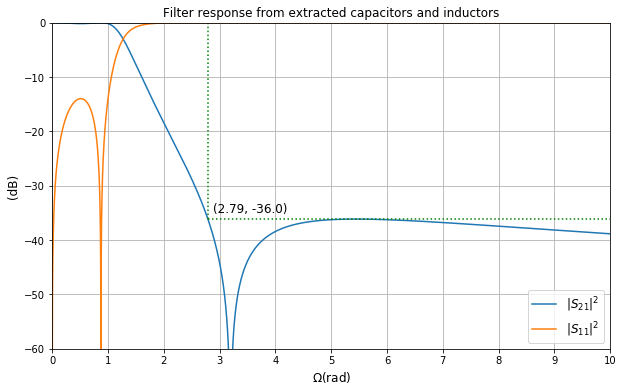

In [39]:
EE = np.array([[terms[0], terms[1]]])
for i in range(len(cap_array)):
        EE = np.append(EE, [[cap_array[i], ind_array[i]]], axis = 0)
#print(EE)  

Sparm = SPARCLad(EE)
S11 = Sparm[0]
S21 = Sparm[1]

wstep = .001
w = np.arange(wstep, 10, wstep)
S11_dB = 20*np.log10(abs(S11(w)) + 1e-8) #1e-8 is added to prevent log(0) condition
S21_dB = 20*np.log10(abs(S21(w)) + 1e-8) #1e-8 is added to prevent log(0) condition

title = 'Filter response from extracted capacitors and inductors'

Plot_S(S11_dB, S21_dB, w, ws, As, title, 2)

___

### List component values
The components and their indicies can be clearly displayed.  
Using dataframes just to display a table is probably an overkill. 

In [40]:
#Component table
#Pad zeros so indices match those of SU
cap_table = np.array([0])
cap_table = np.append(cap_table, cap_array)
cap_table = np.append(cap_table, 0)

ind_table = np.array([0])
ind_table = np.append(ind_table, ind_array)
ind_table = np.append(ind_table, 0)

omega_table = np.array([0])
omega_table = np.append(omega_table, omega_array)
omega_table = np.append(omega_table, 0)

terms_table = np.array(terms[0])
terms_table = np.append(terms_table, np.zeros(n))
terms_table = np.append(terms_table, terms[1])

data = [cap_table, ind_table, omega_table, terms_table] 
df = pd.DataFrame(data, columns = np.arange(0, n+2), index = ['$C$','$L$','${\Omega}$','${R}$'])
df.replace(0, '', inplace = True)
df = df.T
df.style
#print(df)

,$C$,$L$,${\Omega}$,${R}$
0,,,,1
1,1.12149,,,
2,0.0924741,1.05926,3.19513,
3,1.12149,,,
4,,,,1
